# Implementation of semantic segmentation 
## from https://github.com/gnoses 

In [1]:
from PIL import Image
import cPickle as pkl
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
%matplotlib inline  
print ("Packs loaed.")

Packs loaed.


# Load dataset for semantic segmentation

In [2]:
# Location of the files
camvidpath = 'data/seg/SegNet-Tutorial-master/CamVid/'
# Training data
path1 = os.getcwd() + '/' + camvidpath + 'train/'
path2 = os.getcwd() + '/' + camvidpath + 'trainannot/'
trainimglist = glob.glob(path1 + '/*.png')
trainannotlist = glob.glob(path2 + '/*.png')
print ("%d train images" % (len(trainimglist)))
print ("%d train annotations" % (len(trainannotlist)))

# Test data
path1 = os.getcwd() + '/' + camvidpath + 'test/'
path2 = os.getcwd() + '/' + camvidpath + 'testannot/'
testimglist = glob.glob(path1 + '/*.png')
testannotlist = glob.glob(path2 + '/*.png')
print ("%d test images" % (len(testimglist)))
print ("%d test annotations" % (len(testannotlist)))

367 train images
367 train annotations
233 test images
233 test annotations


# Get train / test images

In [3]:
height = 128
width = 128
nrclass = 22
trainData = None
trainLabel = None
trainLabelOneHot = None
trainlen = len(trainimglist)
testData = None
testLabel = None
testLabelOneHot = None
testlen = len(testimglist)
def DenseToOneHot(labels_dense, num_classes):
    # Convert class labels from scalars to one-hot vectors. 
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot
""" Train data process """ 
for (f1, f2, i) in zip(trainimglist, trainannotlist, range(trainlen)):
    # print ("[%02d/%02d]f1: %sf2: %s" % (i, trainlen, f1, f2))
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb  = np.array(img1).reshape(1, height, width, 3)
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    # Stack images and labels
    if i == 0: 
        trainData = rgb
        trainLabel = label
    else:
        trainData = np.concatenate((trainData, rgb), axis=0)
        trainLabel = np.concatenate((trainLabel, label), axis=0)
ntrain = len(trainData)
# Onehot-coded label
trainLabelOneHot = np.zeros((trainLabel.shape[0], trainLabel.shape[1], trainLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = trainLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367,) => (367, 22)
        trainLabelOneHot[:, row, col, :] = oneHot
print ("Train data process done.")        
""" Test data process """ 
for (f1, f2, i) in zip(testimglist, testannotlist, range(testlen)):
    # print ("[%02d/%02d]f1: %sf2: %s" % (i, testlen, f1, f2))
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb  = np.array(img1).reshape(1, height, width, 3)
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    # Stack images and labels
    if i == 0: 
        testData = rgb
        testLabel = label
    else:
        testData = np.concatenate((testData, rgb), axis=0)
        testLabel = np.concatenate((testLabel, label), axis=0)
# Onehot-coded label
testLabelOneHot = np.zeros((testLabel.shape[0], testLabel.shape[1], testLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = testLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367,) => (367, 22)
        testLabelOneHot[:, row, col, :] = oneHot
print ("Test data process done.")

Train data process done.
Test data process done.


In [4]:
print ("Shape of 'trainData' is %s" % (trainData.shape,))
print ("Shape of 'trainLabel' is %s" % (trainLabel.shape,))
print ("Shape of 'trainLabelOneHot' is %s" % (trainLabelOneHot.shape,))
print ("Shape of 'testData' is %s" % (testData.shape,))
print ("Shape of 'testLabel' is %s" % (testLabel.shape,))
print ("Shape of 'testLabelOneHot' is %s" % (testLabelOneHot.shape,))

Shape of 'trainData' is (367, 128, 128, 3)
Shape of 'trainLabel' is (367, 128, 128, 1)
Shape of 'trainLabelOneHot' is (367, 128, 128, 22)
Shape of 'testData' is (233, 128, 128, 3)
Shape of 'testLabel' is (233, 128, 128, 1)
Shape of 'testLabelOneHot' is (233, 128, 128, 22)


# Define networks

In [5]:
# Define functions
x = tf.placeholder(tf.float32, [None, height, width, 3])
y = tf.placeholder(tf.float32, [None, height, width, nrclass])
keepprob = tf.placeholder(tf.float32)
# Kernels
ksize = 7
fsize = 64
initstdev = 0.1
# initfun = tf.random_normal_initializer(mean=0.0, stddev=initstdev))
initfun = None
weights = {
    'ce1': tf.get_variable("ce1", shape = [ksize, ksize, 3, fsize], initializer = initfun) ,
    'ce2': tf.get_variable("ce2", shape = [ksize, ksize, fsize, fsize], initializer = initfun) ,
    'ce3': tf.get_variable("ce3", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'ce4': tf.get_variable("ce4", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd4': tf.get_variable("cd4", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd3': tf.get_variable("cd3", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd2': tf.get_variable("cd2", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd1': tf.get_variable("cd1", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'dense_inner_prod': tf.get_variable("dense_inner_prod", shape= [1, 1, fsize, nrclass]
                                       , initializer = initfun) # <= 1x1conv
}
biases = {
    'be1': tf.get_variable("be1", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be2': tf.get_variable("be2", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be3': tf.get_variable("be3", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be4': tf.get_variable("be4", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd4': tf.get_variable("bd4", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd3': tf.get_variable("bd3", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd2': tf.get_variable("bd2", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd1': tf.get_variable("bd1", shape = [fsize], initializer = tf.constant_initializer(value=0.0))
}

In [6]:
# input : [m, h, w, c]
def Unpooling(inputOrg, size, mask=None):
    # m, c, h, w order
    m = size[0]
    h = size[1]
    w = size[2]
    c = size[3]
    input = tf.transpose(inputOrg, [0, 3, 1, 2])
    x = tf.reshape(input, [-1, 1])
    k = np.float32(np.array([1.0, 1.0]).reshape([1,-1]))
    output = tf.matmul(x, k)
    output = tf.reshape(output,[-1, c, h, w * 2])
    # m, c, w, h
    xx = tf.transpose(output, [0, 1, 3, 2])
    xx = tf.reshape(xx,[-1, 1])
    output = tf.matmul(xx, k)
    # m, c, w, h
    output = tf.reshape(output, [-1, c, w * 2, h * 2])
    output = tf.transpose(output, [0, 3, 2, 1])
    outshape = tf.pack([m, h * 2, w * 2, c])
    if mask != None:
        dense_mask = tf.sparse_to_dense(mask, outshape, output, 0)
        return output, dense_mask
    else:
        return output

# DeconvNet Model
def Model(_X, _W, _b, _keepprob):
    use_bias = 0
    # Encoder 128x128
    encoder1 = tf.nn.conv2d(_X, _W['ce1'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder1 = tf.nn.bias_add(encoder1, _b['be1'])
    encoder1 = tf.nn.batch_normalization(encoder1,0.001,1.0,0,1,0.0001)
    encoder1 = tf.nn.relu(encoder1)
    encoder1 = tf.nn.max_pool(encoder1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder1 = tf.nn.dropout(encoder1, _keepprob)
    # 64x64
    encoder2 = tf.nn.conv2d(encoder1, _W['ce2'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder2 = tf.nn.bias_add(encoder2, _b['be2'])
    encoder2 = tf.nn.batch_normalization(encoder2, 0.001, 1.0, 0, 1, 0.0001)
    encoder2 = tf.nn.relu(encoder2)
    encoder2 = tf.nn.max_pool(encoder2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder2 = tf.nn.dropout(encoder2, _keepprob)
    # 32x32
    encoder3 = tf.nn.conv2d(encoder2, _W['ce3'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder3 = tf.nn.bias_add(encoder3, _b['be3'])
    encoder3 = tf.nn.batch_normalization(encoder3, 0.001, 1.0, 0, 1, 0.0001)
    encoder3 = tf.nn.relu(encoder3)
    encoder3 = tf.nn.max_pool(encoder3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder3 = tf.nn.dropout(encoder3, _keepprob)
    # 16x16
    encoder4 = tf.nn.conv2d(encoder3, _W['ce4'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder4 = tf.nn.bias_add(encoder4, _b['be4'])
    encoder4 = tf.nn.batch_normalization(encoder4, 0.001, 1.0, 0, 1, 0.0001)
    encoder4 = tf.nn.relu(encoder4)
    encoder4 = tf.nn.max_pool(encoder4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder4 = tf.nn.dropout(encoder4, _keepprob)
    # 8x8

    # Decoder 8x8 (128/16 = 8) fsize: 64
    decoder4 = Unpooling(encoder4, [tf.shape(_X)[0], height / 16, width / 16, fsize])
    decoder4 = tf.nn.conv2d(decoder4, _W['cd4'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder4 = tf.nn.bias_add(decoder4, _b['bd4'])
    decoder4 = tf.nn.batch_normalization(decoder4, 0.001, 1.0, 0, 1, 0.0001)
    decoder4 = tf.nn.relu(decoder4)
    decoder4 = tf.nn.dropout(decoder4, _keepprob)
    # 16x16
    decoder3 = Unpooling(encoder3, [tf.shape(_X)[0], height/8, width/8, fsize])
    decoder3 = tf.nn.conv2d(decoder3, _W['cd3'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder3 = tf.nn.bias_add(decoder3, _b['bd3'])
    decoder3 = tf.nn.batch_normalization(decoder3, 0.001, 1.0, 0, 1, 0.0001)
    decoder3 = tf.nn.relu(decoder3)
    decoder3 = tf.nn.dropout(decoder3, _keepprob)
    # 32x32
    decoder2 = Unpooling(decoder3, [tf.shape(_X)[0], height/4, width/4, fsize])
    decoder2 = tf.nn.conv2d(decoder2, _W['cd2'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder2 = tf.nn.bias_add(decoder2, _b['bd2'])
    decoder2 = tf.nn.batch_normalization(decoder2, 0.001, 1.0, 0, 1, 0.0001)
    decoder2 = tf.nn.relu(decoder2)
    decoder2 = tf.nn.dropout(decoder2, _keepprob)
    # 64x64
    decoder1 = Unpooling(decoder2, [tf.shape(_X)[0], height / 2, width / 2, fsize])
    decoder1 = tf.nn.conv2d(decoder1, _W['cd1'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder1 = tf.nn.bias_add(decoder1, _b['bd1'])
    decoder1 = tf.nn.batch_normalization(decoder1, 0.001, 1.0, 0, 1.0, 0.0001)
    decoder1 = tf.nn.relu(decoder1)
    decoder1 = tf.nn.dropout(decoder1, _keepprob)
    # 128x128
    output = tf.nn.conv2d(decoder1, _W['dense_inner_prod'], strides=[1, 1, 1, 1], padding='SAME')
    return output

print ("Network ready")

Network ready


# Define functions

In [ ]:
pred = Model(x, weights, biases, keepprob)
lin_pred = tf.reshape(pred, shape=[-1, nrclass])
lin_y = tf.reshape(y, shape=[-1, nrclass])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(lin_pred, lin_y))
# Class label
predmax = tf.argmax(pred, 3)
ymax = tf.argmax(y, 3)
# Accuracy
corr = tf.equal(tf.argmax(y,3), tf.argmax(pred, 3)) 
accr = tf.reduce_mean(tf.cast(corr, "float"))
# Optimizer
optm = tf.train.AdamOptimizer(0.0001).minimize(cost)
batch_size = 128
n_epochs = 1000

# Real optimization starts here

checkpoint: None
Couldn't find checkpoint to restore from. Starting over.
[00/1000] trainLoss: 4.7912 trainAcc: 0.19 valLoss: 3.6190 valAcc: 0.16


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


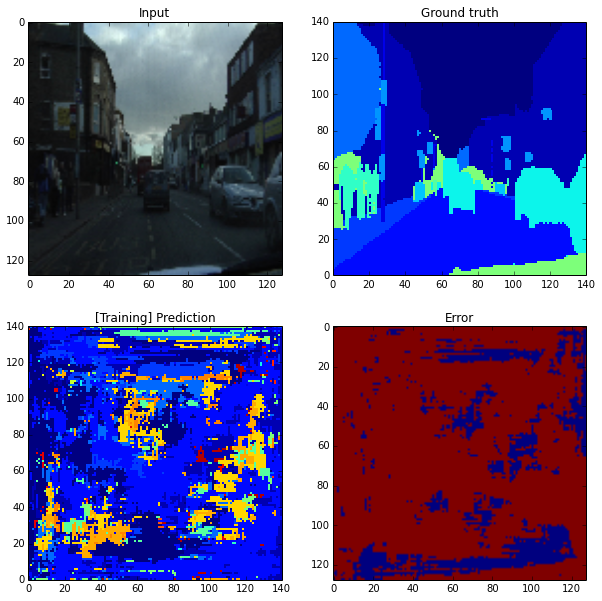

[01/1000] trainLoss: 3.0248 trainAcc: 0.20 valLoss: 2.8365 valAcc: 0.21
[02/1000] trainLoss: 2.6743 trainAcc: 0.20 valLoss: 2.6283 valAcc: 0.22
[03/1000] trainLoss: 2.7078 trainAcc: 0.24 valLoss: 2.7788 valAcc: 0.26
[04/1000] trainLoss: 2.8404 trainAcc: 0.27 valLoss: 2.8762 valAcc: 0.28
[05/1000] trainLoss: 2.8896 trainAcc: 0.30 valLoss: 2.8998 valAcc: 0.30
[06/1000] trainLoss: 2.8851 trainAcc: 0.34 valLoss: 2.8896 valAcc: 0.32
[07/1000] trainLoss: 2.8533 trainAcc: 0.37 valLoss: 2.8511 valAcc: 0.33
[08/1000] trainLoss: 2.7728 trainAcc: 0.38 valLoss: 2.7614 valAcc: 0.34
[09/1000] trainLoss: 2.6919 trainAcc: 0.38 valLoss: 2.7181 valAcc: 0.33
[10/1000] trainLoss: 2.6955 trainAcc: 0.38 valLoss: 2.7363 valAcc: 0.32


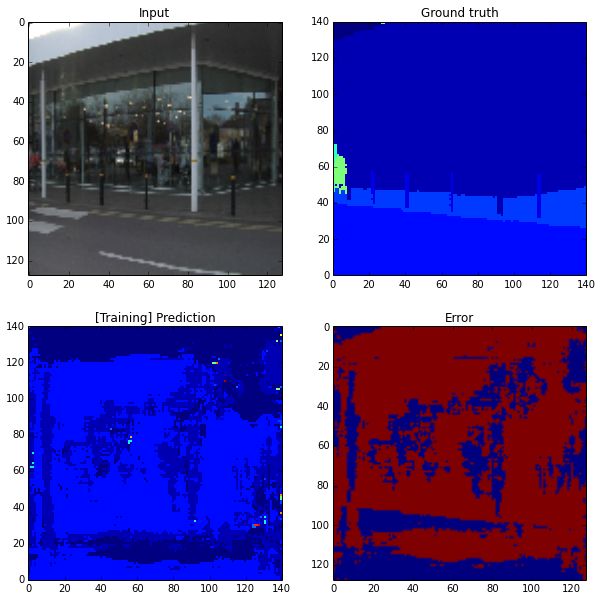

[11/1000] trainLoss: 2.6971 trainAcc: 0.37 valLoss: 2.7242 valAcc: 0.31
[12/1000] trainLoss: 2.6639 trainAcc: 0.36 valLoss: 2.6828 valAcc: 0.32
[13/1000] trainLoss: 2.6261 trainAcc: 0.36 valLoss: 2.6481 valAcc: 0.32
[14/1000] trainLoss: 2.6056 trainAcc: 0.37 valLoss: 2.6462 valAcc: 0.33
[15/1000] trainLoss: 2.6048 trainAcc: 0.39 valLoss: 2.6595 valAcc: 0.34
[16/1000] trainLoss: 2.6027 trainAcc: 0.41 valLoss: 2.6503 valAcc: 0.36
[17/1000] trainLoss: 2.5800 trainAcc: 0.42 valLoss: 2.6363 valAcc: 0.37
[18/1000] trainLoss: 2.5492 trainAcc: 0.44 valLoss: 2.6119 valAcc: 0.38
[19/1000] trainLoss: 2.5251 trainAcc: 0.45 valLoss: 2.5981 valAcc: 0.40
[20/1000] trainLoss: 2.5180 trainAcc: 0.45 valLoss: 2.5882 valAcc: 0.41


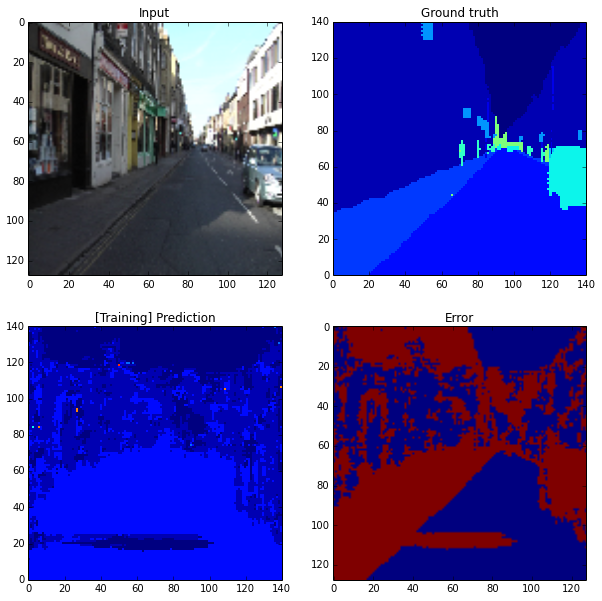

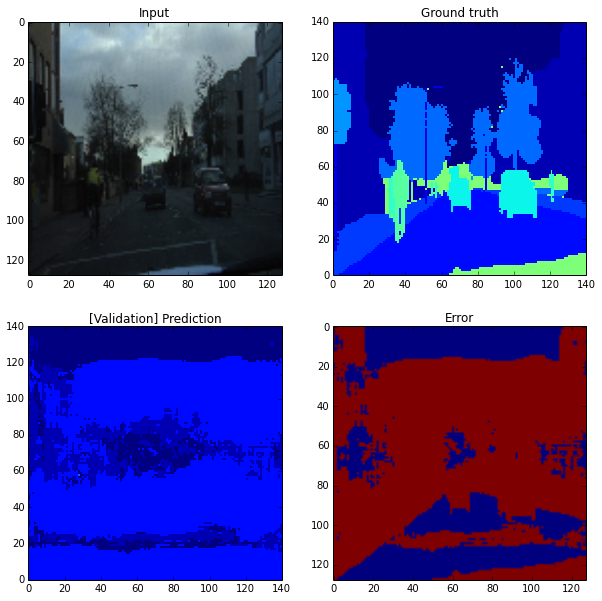

[21/1000] trainLoss: 2.4925 trainAcc: 0.47 valLoss: 2.5741 valAcc: 0.42
[22/1000] trainLoss: 2.4709 trainAcc: 0.48 valLoss: 2.5588 valAcc: 0.43
[23/1000] trainLoss: 2.4689 trainAcc: 0.49 valLoss: 2.5606 valAcc: 0.45
[24/1000] trainLoss: 2.4581 trainAcc: 0.50 valLoss: 2.5567 valAcc: 0.45
[25/1000] trainLoss: 2.4159 trainAcc: 0.52 valLoss: 2.5419 valAcc: 0.46
[26/1000] trainLoss: 2.4038 trainAcc: 0.51 valLoss: 2.5311 valAcc: 0.45
[27/1000] trainLoss: 2.3749 trainAcc: 0.51 valLoss: 2.4858 valAcc: 0.46
[28/1000] trainLoss: 2.3020 trainAcc: 0.52 valLoss: 2.4334 valAcc: 0.47
[29/1000] trainLoss: 2.2696 trainAcc: 0.52 valLoss: 2.3954 valAcc: 0.47
[30/1000] trainLoss: 2.1951 trainAcc: 0.55 valLoss: 2.3625 valAcc: 0.48


[31/1000] trainLoss: 2.1576 trainAcc: 0.56 valLoss: 2.3321 valAcc: 0.50
[32/1000] trainLoss: 2.1440 trainAcc: 0.57 valLoss: 2.3182 valAcc: 0.51
[33/1000] trainLoss: 2.1294 trainAcc: 0.57 valLoss: 2.2993 valAcc: 0.51
[34/1000] trainLoss: 2.0999 trainAcc: 0.57 valLoss: 2.2647 valAcc: 0.51
[35/1000] trainLoss: 2.1072 trainAcc: 0.57 valLoss: 2.2901 valAcc: 0.50
[36/1000] trainLoss: 2.1087 trainAcc: 0.57 valLoss: 2.2475 valAcc: 0.51
[37/1000] trainLoss: 2.0293 trainAcc: 0.59 valLoss: 2.2252 valAcc: 0.52
[38/1000] trainLoss: 2.0625 trainAcc: 0.59 valLoss: 2.2270 valAcc: 0.53
[39/1000] trainLoss: 2.0590 trainAcc: 0.61 valLoss: 2.2017 valAcc: 0.54
[40/1000] trainLoss: 2.0495 trainAcc: 0.61 valLoss: 2.1845 valAcc: 0.55


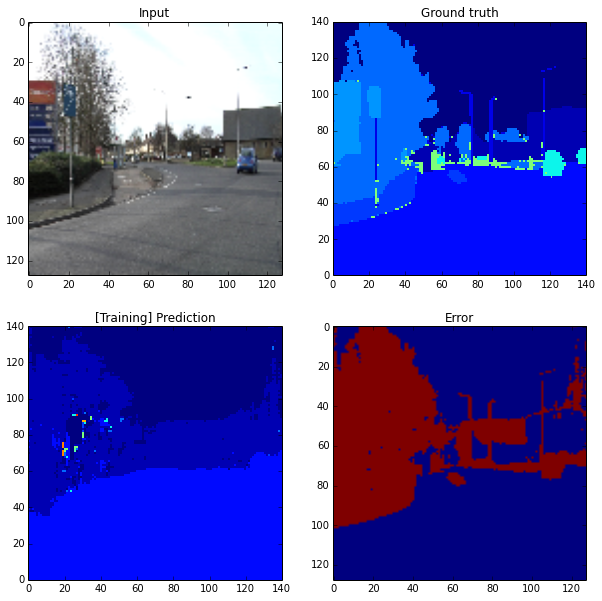

[41/1000] trainLoss: 2.0185 trainAcc: 0.62 valLoss: 2.1452 valAcc: 0.56
[42/1000] trainLoss: 2.0198 trainAcc: 0.62 valLoss: 2.1427 valAcc: 0.56
[43/1000] trainLoss: 2.0275 trainAcc: 0.63 valLoss: 2.1423 valAcc: 0.56
[44/1000] trainLoss: 1.9824 trainAcc: 0.64 valLoss: 2.0748 valAcc: 0.57
[45/1000] trainLoss: 1.9799 trainAcc: 0.63 valLoss: 2.1153 valAcc: 0.57
[46/1000] trainLoss: 2.0057 trainAcc: 0.63 valLoss: 2.1151 valAcc: 0.56
[47/1000] trainLoss: 1.9445 trainAcc: 0.64 valLoss: 2.0441 valAcc: 0.57
[48/1000] trainLoss: 1.9390 trainAcc: 0.64 valLoss: 2.0486 valAcc: 0.57
[49/1000] trainLoss: 1.9570 trainAcc: 0.63 valLoss: 2.0703 valAcc: 0.57
[50/1000] trainLoss: 1.9829 trainAcc: 0.64 valLoss: 2.0953 valAcc: 0.57


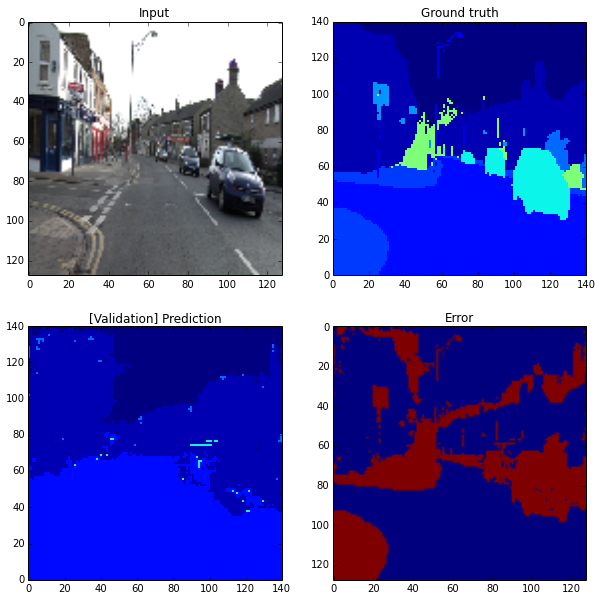

[51/1000] trainLoss: 1.9727 trainAcc: 0.64 valLoss: 2.0551 valAcc: 0.57
[52/1000] trainLoss: 1.9279 trainAcc: 0.65 valLoss: 2.0491 valAcc: 0.57
[53/1000] trainLoss: 1.9615 trainAcc: 0.64 valLoss: 2.0553 valAcc: 0.57
[54/1000] trainLoss: 1.9964 trainAcc: 0.62 valLoss: 2.0987 valAcc: 0.57
[55/1000] trainLoss: 1.9809 trainAcc: 0.64 valLoss: 2.0466 valAcc: 0.57
[56/1000] trainLoss: 1.9332 trainAcc: 0.64 valLoss: 2.0339 valAcc: 0.57
[57/1000] trainLoss: 1.9468 trainAcc: 0.63 valLoss: 2.0706 valAcc: 0.57
[58/1000] trainLoss: 1.9907 trainAcc: 0.63 valLoss: 2.0326 valAcc: 0.57
[59/1000] trainLoss: 1.9289 trainAcc: 0.64 valLoss: 2.0120 valAcc: 0.57
[60/1000] trainLoss: 1.9355 trainAcc: 0.63 valLoss: 2.0247 valAcc: 0.57


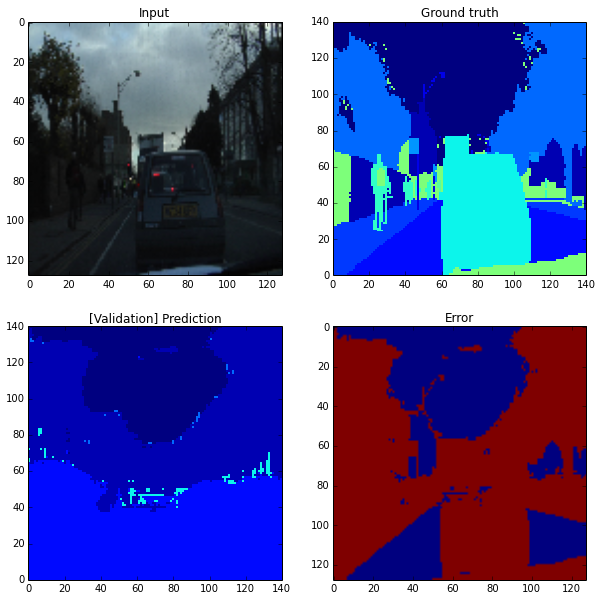

[61/1000] trainLoss: 1.9466 trainAcc: 0.63 valLoss: 2.0345 valAcc: 0.57
[62/1000] trainLoss: 1.9512 trainAcc: 0.62 valLoss: 2.0187 valAcc: 0.57
[63/1000] trainLoss: 1.8904 trainAcc: 0.63 valLoss: 1.9911 valAcc: 0.57
[64/1000] trainLoss: 1.9393 trainAcc: 0.63 valLoss: 2.0359 valAcc: 0.57
[65/1000] trainLoss: 1.9090 trainAcc: 0.63 valLoss: 1.9891 valAcc: 0.57
[66/1000] trainLoss: 1.8893 trainAcc: 0.64 valLoss: 1.9899 valAcc: 0.57
[67/1000] trainLoss: 1.9088 trainAcc: 0.63 valLoss: 1.9946 valAcc: 0.57
[68/1000] trainLoss: 1.9037 trainAcc: 0.64 valLoss: 1.9997 valAcc: 0.57
[69/1000] trainLoss: 1.8995 trainAcc: 0.64 valLoss: 1.9390 valAcc: 0.58
[70/1000] trainLoss: 1.8684 trainAcc: 0.64 valLoss: 1.9797 valAcc: 0.57


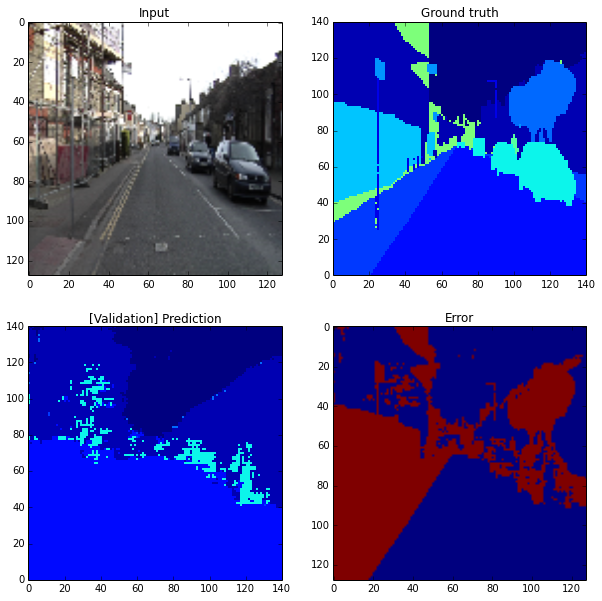

[71/1000] trainLoss: 1.8909 trainAcc: 0.64 valLoss: 1.9747 valAcc: 0.57
[72/1000] trainLoss: 1.8827 trainAcc: 0.64 valLoss: 1.9482 valAcc: 0.57
[73/1000] trainLoss: 1.8451 trainAcc: 0.66 valLoss: 1.9216 valAcc: 0.57
[74/1000] trainLoss: 1.8505 trainAcc: 0.64 valLoss: 1.9593 valAcc: 0.56
[75/1000] trainLoss: 1.8657 trainAcc: 0.64 valLoss: 1.9384 valAcc: 0.58
[76/1000] trainLoss: 1.8229 trainAcc: 0.66 valLoss: 1.8979 valAcc: 0.57
[77/1000] trainLoss: 1.8327 trainAcc: 0.65 valLoss: 1.9040 valAcc: 0.56
[78/1000] trainLoss: 1.8004 trainAcc: 0.66 valLoss: 1.8932 valAcc: 0.57
[79/1000] trainLoss: 1.8257 trainAcc: 0.65 valLoss: 1.9219 valAcc: 0.57
[80/1000] trainLoss: 1.7807 trainAcc: 0.66 valLoss: 1.8488 valAcc: 0.57


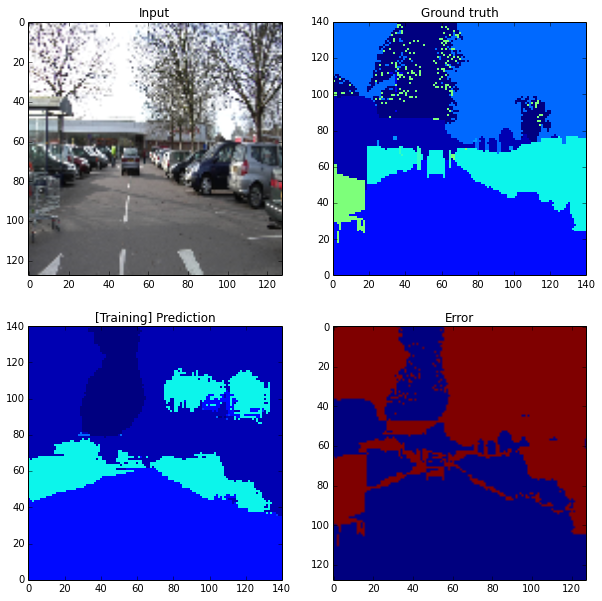

[81/1000] trainLoss: 1.7676 trainAcc: 0.67 valLoss: 1.8792 valAcc: 0.57
[82/1000] trainLoss: 1.7443 trainAcc: 0.66 valLoss: 1.8409 valAcc: 0.58
[83/1000] trainLoss: 1.7682 trainAcc: 0.66 valLoss: 1.8757 valAcc: 0.57
[84/1000] trainLoss: 1.7655 trainAcc: 0.66 valLoss: 1.8368 valAcc: 0.58
[85/1000] trainLoss: 1.7510 trainAcc: 0.67 valLoss: 1.8371 valAcc: 0.58
[86/1000] trainLoss: 1.7688 trainAcc: 0.66 valLoss: 1.8410 valAcc: 0.58
[87/1000] trainLoss: 1.6669 trainAcc: 0.68 valLoss: 1.7900 valAcc: 0.59
[88/1000] trainLoss: 1.7206 trainAcc: 0.66 valLoss: 1.8356 valAcc: 0.58
[89/1000] trainLoss: 1.7193 trainAcc: 0.67 valLoss: 1.8063 valAcc: 0.58
[90/1000] trainLoss: 1.6887 trainAcc: 0.68 valLoss: 1.7918 valAcc: 0.59


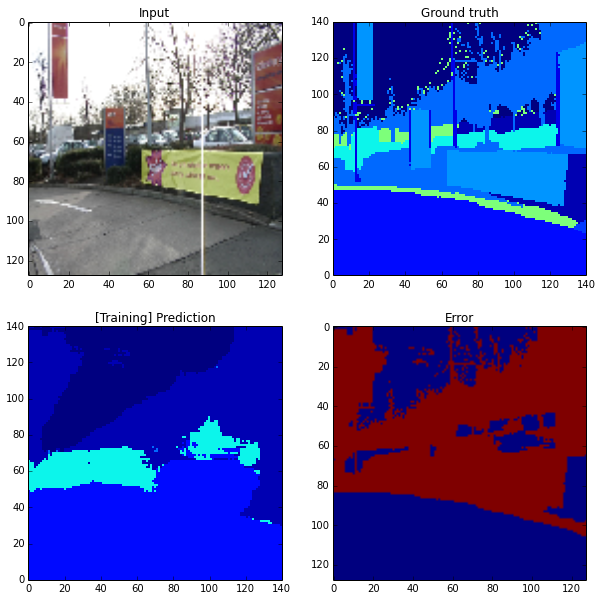

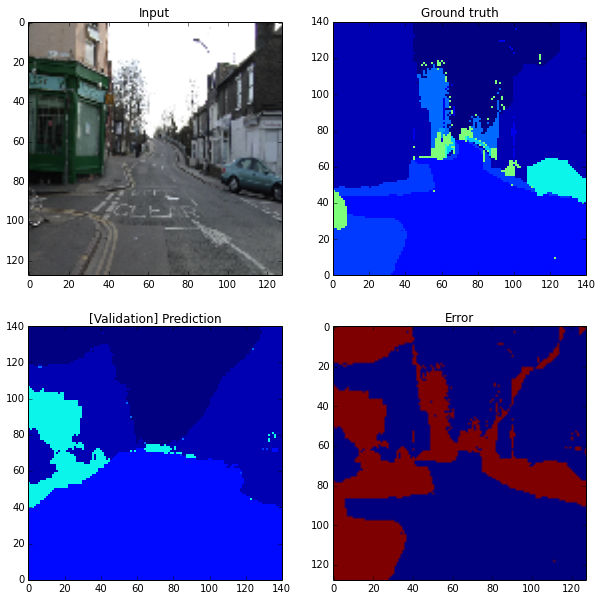

[91/1000] trainLoss: 1.6964 trainAcc: 0.66 valLoss: 1.7755 valAcc: 0.59
[92/1000] trainLoss: 1.7016 trainAcc: 0.67 valLoss: 1.8008 valAcc: 0.58
[93/1000] trainLoss: 1.6600 trainAcc: 0.68 valLoss: 1.7762 valAcc: 0.59
[94/1000] trainLoss: 1.6871 trainAcc: 0.67 valLoss: 1.7536 valAcc: 0.59
[95/1000] trainLoss: 1.6269 trainAcc: 0.69 valLoss: 1.7594 valAcc: 0.59
[96/1000] trainLoss: 1.6895 trainAcc: 0.68 valLoss: 1.7587 valAcc: 0.59
[97/1000] trainLoss: 1.6608 trainAcc: 0.68 valLoss: 1.7626 valAcc: 0.59
[98/1000] trainLoss: 1.6219 trainAcc: 0.68 valLoss: 1.7194 valAcc: 0.59
[99/1000] trainLoss: 1.6671 trainAcc: 0.66 valLoss: 1.7985 valAcc: 0.59
[100/1000] trainLoss: 1.6542 trainAcc: 0.67 valLoss: 1.7641 valAcc: 0.59


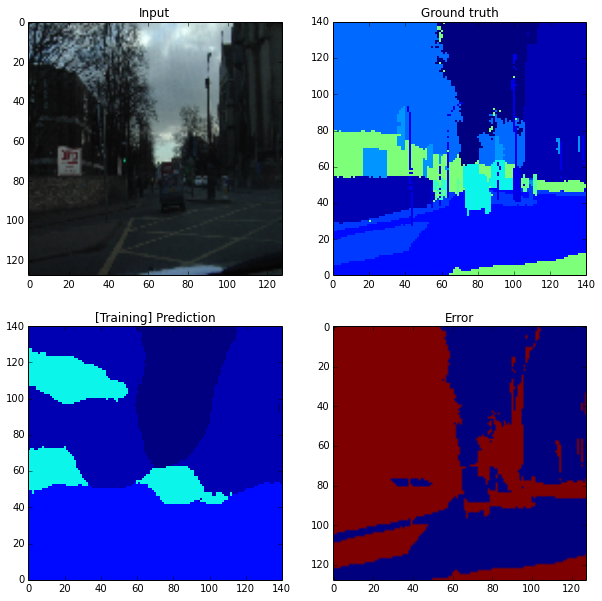

[101/1000] trainLoss: 1.5986 trainAcc: 0.68 valLoss: 1.7189 valAcc: 0.59
[102/1000] trainLoss: 1.6005 trainAcc: 0.68 valLoss: 1.7363 valAcc: 0.60
[103/1000] trainLoss: 1.6518 trainAcc: 0.67 valLoss: 1.7536 valAcc: 0.59
[104/1000] trainLoss: 1.6344 trainAcc: 0.68 valLoss: 1.7507 valAcc: 0.59
[105/1000] trainLoss: 1.5861 trainAcc: 0.68 valLoss: 1.7022 valAcc: 0.60
[106/1000] trainLoss: 1.6508 trainAcc: 0.67 valLoss: 1.7442 valAcc: 0.59
[107/1000] trainLoss: 1.6037 trainAcc: 0.68 valLoss: 1.7251 valAcc: 0.59
[108/1000] trainLoss: 1.6035 trainAcc: 0.68 valLoss: 1.6807 valAcc: 0.60
[109/1000] trainLoss: 1.5800 trainAcc: 0.67 valLoss: 1.7089 valAcc: 0.60
[110/1000] trainLoss: 1.6143 trainAcc: 0.67 valLoss: 1.6989 valAcc: 0.60


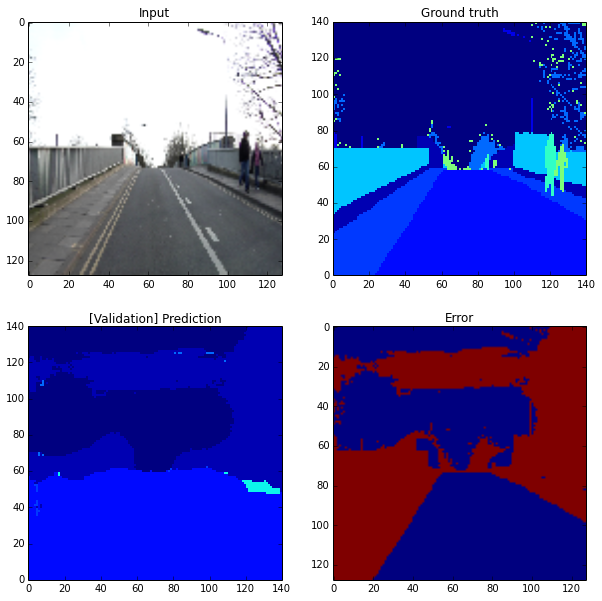

[111/1000] trainLoss: 1.5834 trainAcc: 0.68 valLoss: 1.7186 valAcc: 0.59
[112/1000] trainLoss: 1.5800 trainAcc: 0.68 valLoss: 1.6535 valAcc: 0.60
[113/1000] trainLoss: 1.5630 trainAcc: 0.68 valLoss: 1.7096 valAcc: 0.59
[114/1000] trainLoss: 1.5873 trainAcc: 0.68 valLoss: 1.6853 valAcc: 0.60
[115/1000] trainLoss: 1.5458 trainAcc: 0.69 valLoss: 1.6850 valAcc: 0.60
[116/1000] trainLoss: 1.5641 trainAcc: 0.68 valLoss: 1.6647 valAcc: 0.60
[117/1000] trainLoss: 1.5798 trainAcc: 0.68 valLoss: 1.6862 valAcc: 0.60
[118/1000] trainLoss: 1.5463 trainAcc: 0.69 valLoss: 1.6580 valAcc: 0.60
[119/1000] trainLoss: 1.5383 trainAcc: 0.69 valLoss: 1.6487 valAcc: 0.60
[120/1000] trainLoss: 1.5208 trainAcc: 0.69 valLoss: 1.6914 valAcc: 0.59


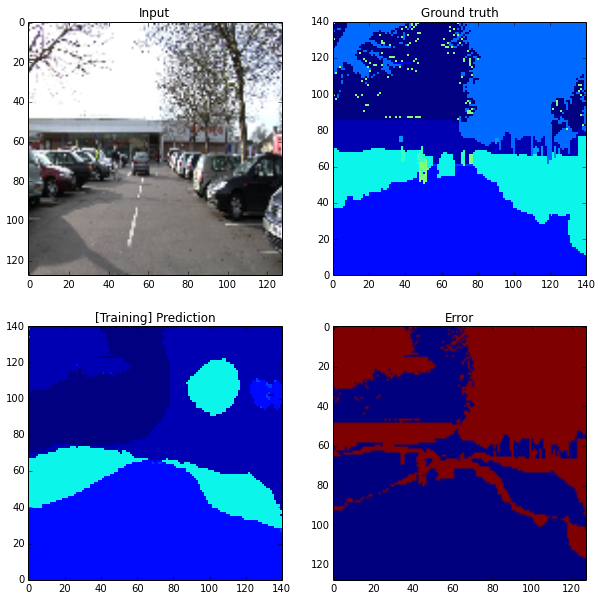

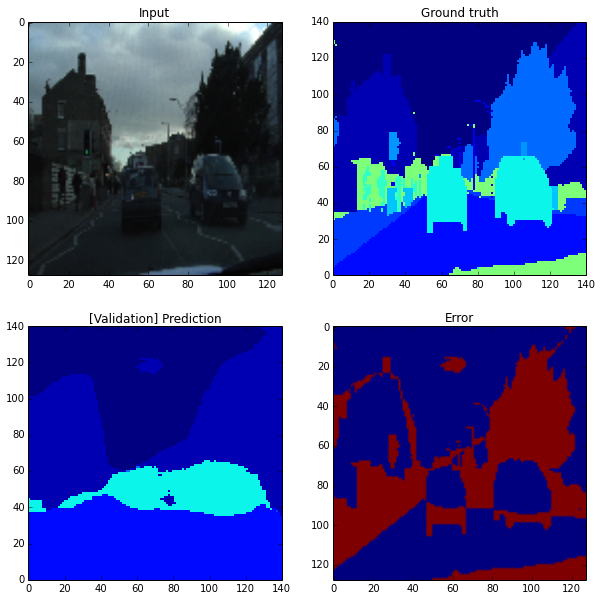

[121/1000] trainLoss: 1.5324 trainAcc: 0.69 valLoss: 1.6374 valAcc: 0.61
[122/1000] trainLoss: 1.5321 trainAcc: 0.69 valLoss: 1.6907 valAcc: 0.60
[123/1000] trainLoss: 1.5393 trainAcc: 0.68 valLoss: 1.6531 valAcc: 0.61
[124/1000] trainLoss: 1.5646 trainAcc: 0.68 valLoss: 1.6852 valAcc: 0.60
[125/1000] trainLoss: 1.5185 trainAcc: 0.70 valLoss: 1.6589 valAcc: 0.61
[126/1000] trainLoss: 1.5318 trainAcc: 0.68 valLoss: 1.6435 valAcc: 0.61
[127/1000] trainLoss: 1.5554 trainAcc: 0.68 valLoss: 1.6849 valAcc: 0.60
[128/1000] trainLoss: 1.5281 trainAcc: 0.69 valLoss: 1.6426 valAcc: 0.61
[129/1000] trainLoss: 1.5270 trainAcc: 0.69 valLoss: 1.6636 valAcc: 0.60
[130/1000] trainLoss: 1.4980 trainAcc: 0.69 valLoss: 1.6299 valAcc: 0.61


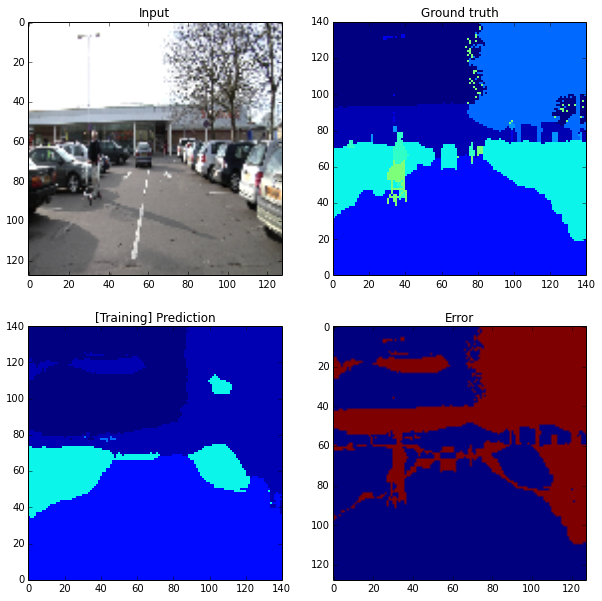

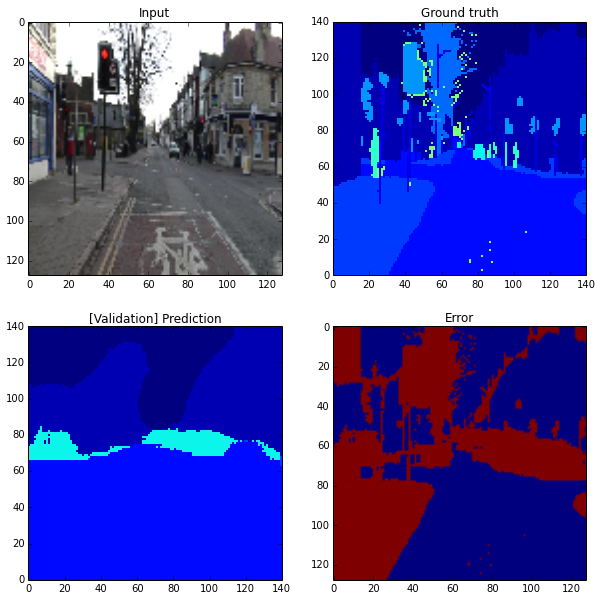

[131/1000] trainLoss: 1.5072 trainAcc: 0.70 valLoss: 1.6640 valAcc: 0.60
[132/1000] trainLoss: 1.5112 trainAcc: 0.69 valLoss: 1.6403 valAcc: 0.61
[133/1000] trainLoss: 1.5357 trainAcc: 0.69 valLoss: 1.6357 valAcc: 0.61
[134/1000] trainLoss: 1.5281 trainAcc: 0.69 valLoss: 1.6637 valAcc: 0.61
[135/1000] trainLoss: 1.5263 trainAcc: 0.69 valLoss: 1.6294 valAcc: 0.61
[136/1000] trainLoss: 1.4974 trainAcc: 0.69 valLoss: 1.6447 valAcc: 0.60
[137/1000] trainLoss: 1.4920 trainAcc: 0.69 valLoss: 1.6164 valAcc: 0.62
[138/1000] trainLoss: 1.5215 trainAcc: 0.69 valLoss: 1.6726 valAcc: 0.60
[139/1000] trainLoss: 1.5041 trainAcc: 0.69 valLoss: 1.6142 valAcc: 0.61
[140/1000] trainLoss: 1.5245 trainAcc: 0.69 valLoss: 1.6498 valAcc: 0.61


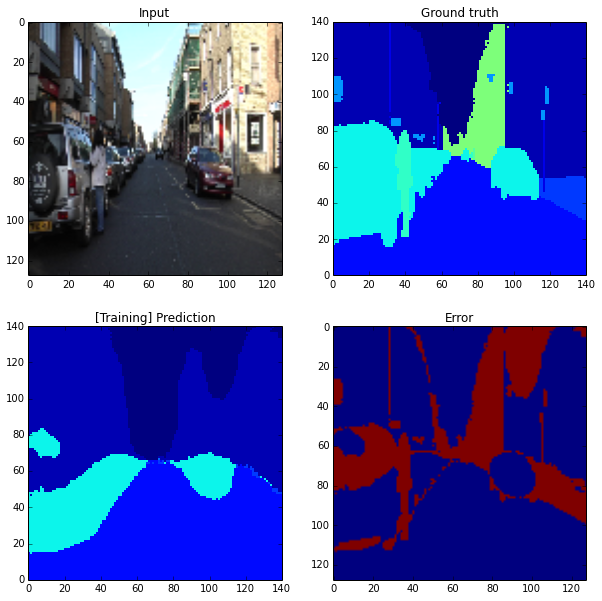

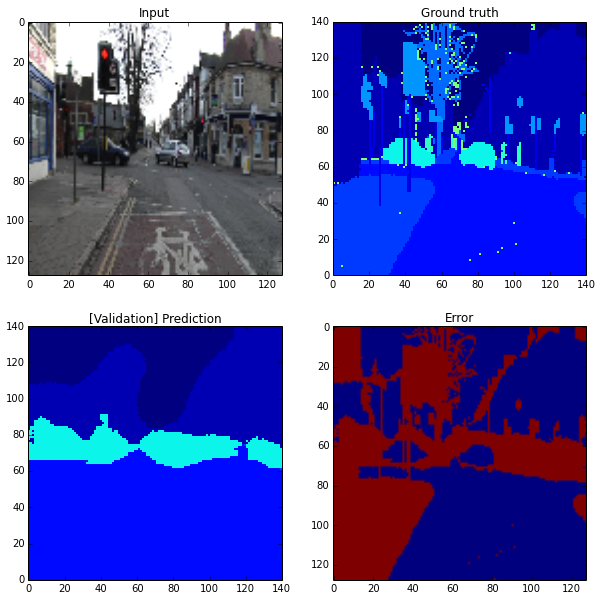

[141/1000] trainLoss: 1.4926 trainAcc: 0.70 valLoss: 1.6396 valAcc: 0.61
[142/1000] trainLoss: 1.5255 trainAcc: 0.68 valLoss: 1.6177 valAcc: 0.61
[143/1000] trainLoss: 1.5148 trainAcc: 0.69 valLoss: 1.6474 valAcc: 0.60
[144/1000] trainLoss: 1.5002 trainAcc: 0.69 valLoss: 1.6186 valAcc: 0.62
[145/1000] trainLoss: 1.5082 trainAcc: 0.69 valLoss: 1.6307 valAcc: 0.60
[146/1000] trainLoss: 1.4534 trainAcc: 0.70 valLoss: 1.6119 valAcc: 0.61
[147/1000] trainLoss: 1.5137 trainAcc: 0.69 valLoss: 1.6127 valAcc: 0.61
[148/1000] trainLoss: 1.4828 trainAcc: 0.69 valLoss: 1.6251 valAcc: 0.60
[149/1000] trainLoss: 1.4968 trainAcc: 0.69 valLoss: 1.6134 valAcc: 0.61
[150/1000] trainLoss: 1.4800 trainAcc: 0.70 valLoss: 1.6252 valAcc: 0.61


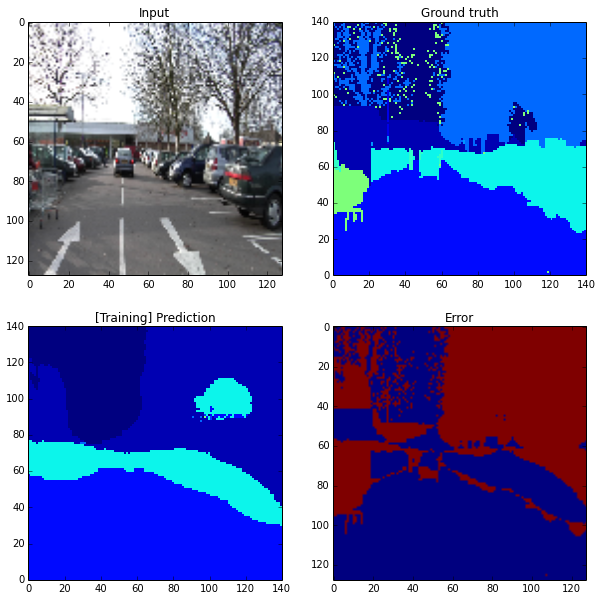

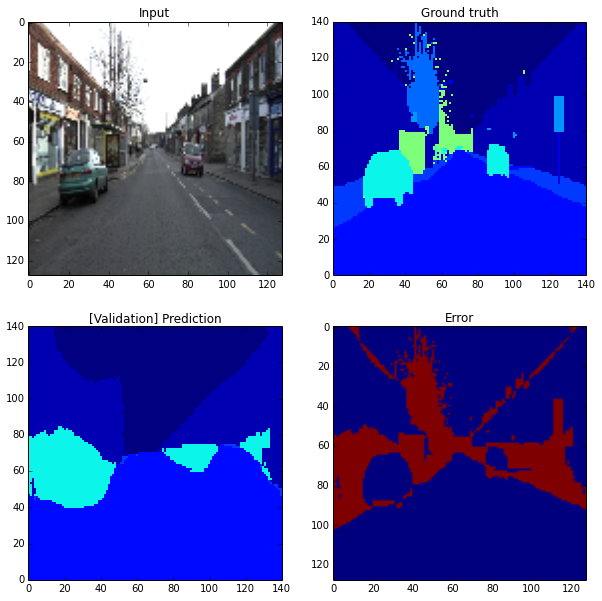

[151/1000] trainLoss: 1.4953 trainAcc: 0.69 valLoss: 1.5838 valAcc: 0.62
[152/1000] trainLoss: 1.5139 trainAcc: 0.69 valLoss: 1.6567 valAcc: 0.60
[153/1000] trainLoss: 1.5197 trainAcc: 0.68 valLoss: 1.6165 valAcc: 0.62
[154/1000] trainLoss: 1.4787 trainAcc: 0.70 valLoss: 1.6344 valAcc: 0.61
[155/1000] trainLoss: 1.4649 trainAcc: 0.70 valLoss: 1.5911 valAcc: 0.62
[156/1000] trainLoss: 1.4775 trainAcc: 0.70 valLoss: 1.6071 valAcc: 0.61
[157/1000] trainLoss: 1.4824 trainAcc: 0.69 valLoss: 1.6111 valAcc: 0.62
[158/1000] trainLoss: 1.4962 trainAcc: 0.69 valLoss: 1.6037 valAcc: 0.62
[159/1000] trainLoss: 1.4766 trainAcc: 0.69 valLoss: 1.6174 valAcc: 0.62
[160/1000] trainLoss: 1.4849 trainAcc: 0.69 valLoss: 1.6080 valAcc: 0.62


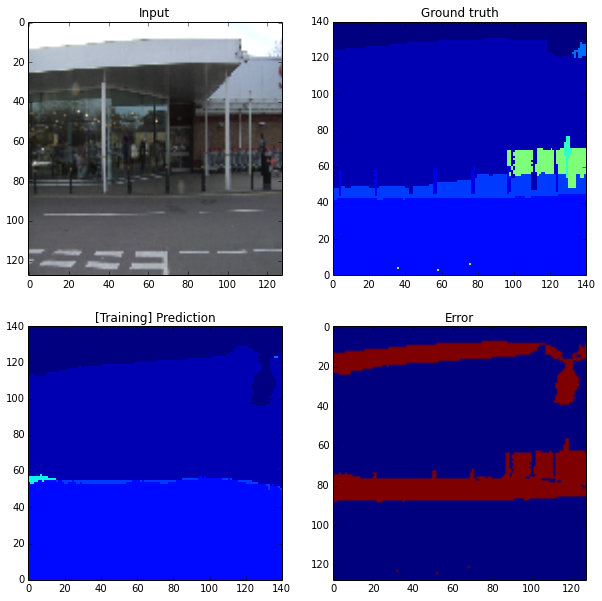

[161/1000] trainLoss: 1.4689 trainAcc: 0.69 valLoss: 1.5885 valAcc: 0.62
[162/1000] trainLoss: 1.4729 trainAcc: 0.69 valLoss: 1.5969 valAcc: 0.62
[163/1000] trainLoss: 1.4700 trainAcc: 0.69 valLoss: 1.6043 valAcc: 0.62
[164/1000] trainLoss: 1.4464 trainAcc: 0.70 valLoss: 1.5938 valAcc: 0.62
[165/1000] trainLoss: 1.4659 trainAcc: 0.69 valLoss: 1.5859 valAcc: 0.62
[166/1000] trainLoss: 1.4677 trainAcc: 0.69 valLoss: 1.5931 valAcc: 0.62
[167/1000] trainLoss: 1.4629 trainAcc: 0.70 valLoss: 1.5960 valAcc: 0.62
[168/1000] trainLoss: 1.4341 trainAcc: 0.70 valLoss: 1.5623 valAcc: 0.62
[169/1000] trainLoss: 1.4429 trainAcc: 0.70 valLoss: 1.5805 valAcc: 0.62
[170/1000] trainLoss: 1.4443 trainAcc: 0.70 valLoss: 1.6061 valAcc: 0.62


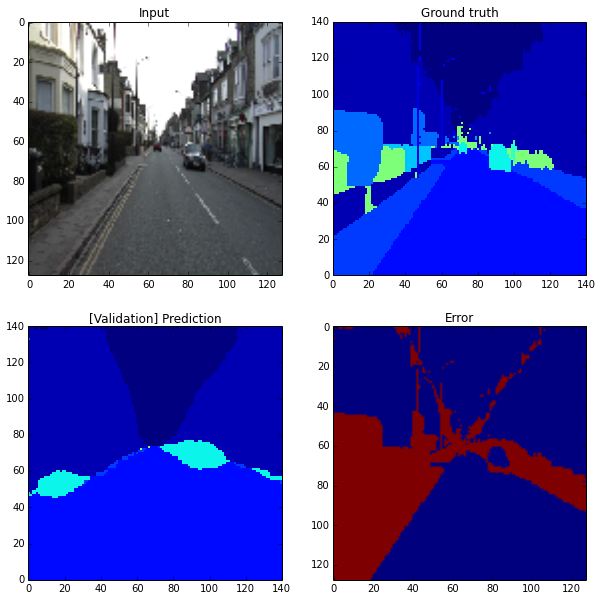

[171/1000] trainLoss: 1.4525 trainAcc: 0.70 valLoss: 1.5634 valAcc: 0.62
[172/1000] trainLoss: 1.4147 trainAcc: 0.71 valLoss: 1.5781 valAcc: 0.62
[173/1000] trainLoss: 1.4396 trainAcc: 0.70 valLoss: 1.5705 valAcc: 0.62
[174/1000] trainLoss: 1.4496 trainAcc: 0.70 valLoss: 1.5756 valAcc: 0.62
[175/1000] trainLoss: 1.4110 trainAcc: 0.71 valLoss: 1.5575 valAcc: 0.62
[176/1000] trainLoss: 1.4339 trainAcc: 0.70 valLoss: 1.5621 valAcc: 0.62
[177/1000] trainLoss: 1.4352 trainAcc: 0.71 valLoss: 1.5803 valAcc: 0.62
[178/1000] trainLoss: 1.4370 trainAcc: 0.70 valLoss: 1.5588 valAcc: 0.62
[179/1000] trainLoss: 1.4533 trainAcc: 0.70 valLoss: 1.5855 valAcc: 0.62
[180/1000] trainLoss: 1.4384 trainAcc: 0.70 valLoss: 1.5573 valAcc: 0.62


[181/1000] trainLoss: 1.4042 trainAcc: 0.71 valLoss: 1.5645 valAcc: 0.62
[182/1000] trainLoss: 1.4495 trainAcc: 0.69 valLoss: 1.5729 valAcc: 0.62
[183/1000] trainLoss: 1.4650 trainAcc: 0.70 valLoss: 1.5941 valAcc: 0.62
[184/1000] trainLoss: 1.4358 trainAcc: 0.71 valLoss: 1.5429 valAcc: 0.63
[185/1000] trainLoss: 1.4120 trainAcc: 0.70 valLoss: 1.5166 valAcc: 0.63
[186/1000] trainLoss: 1.4466 trainAcc: 0.70 valLoss: 1.5949 valAcc: 0.62
[187/1000] trainLoss: 1.4434 trainAcc: 0.70 valLoss: 1.5476 valAcc: 0.63
[188/1000] trainLoss: 1.3929 trainAcc: 0.71 valLoss: 1.5678 valAcc: 0.62
[189/1000] trainLoss: 1.4005 trainAcc: 0.71 valLoss: 1.5343 valAcc: 0.63
[190/1000] trainLoss: 1.4600 trainAcc: 0.70 valLoss: 1.5797 valAcc: 0.63


[191/1000] trainLoss: 1.4304 trainAcc: 0.70 valLoss: 1.5433 valAcc: 0.63
[192/1000] trainLoss: 1.4290 trainAcc: 0.70 valLoss: 1.5491 valAcc: 0.63
[193/1000] trainLoss: 1.4153 trainAcc: 0.70 valLoss: 1.5384 valAcc: 0.63
[194/1000] trainLoss: 1.4629 trainAcc: 0.69 valLoss: 1.5614 valAcc: 0.63
[195/1000] trainLoss: 1.4135 trainAcc: 0.71 valLoss: 1.5531 valAcc: 0.63
[196/1000] trainLoss: 1.4459 trainAcc: 0.69 valLoss: 1.5196 valAcc: 0.63
[197/1000] trainLoss: 1.4084 trainAcc: 0.71 valLoss: 1.5576 valAcc: 0.63
[198/1000] trainLoss: 1.4395 trainAcc: 0.70 valLoss: 1.5546 valAcc: 0.63
[199/1000] trainLoss: 1.4295 trainAcc: 0.71 valLoss: 1.5260 valAcc: 0.63
[200/1000] trainLoss: 1.4095 trainAcc: 0.70 valLoss: 1.5376 valAcc: 0.63


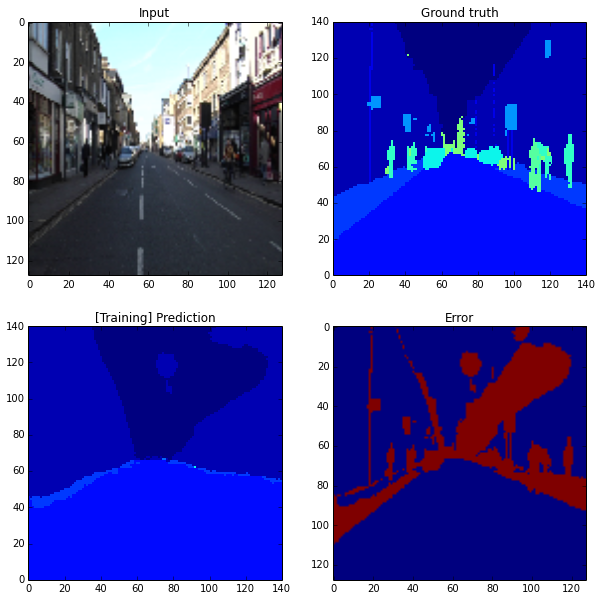

[201/1000] trainLoss: 1.4078 trainAcc: 0.70 valLoss: 1.5435 valAcc: 0.63
[202/1000] trainLoss: 1.4098 trainAcc: 0.70 valLoss: 1.5322 valAcc: 0.63
[203/1000] trainLoss: 1.4154 trainAcc: 0.70 valLoss: 1.5452 valAcc: 0.63
[204/1000] trainLoss: 1.3964 trainAcc: 0.71 valLoss: 1.5361 valAcc: 0.63
[205/1000] trainLoss: 1.3857 trainAcc: 0.71 valLoss: 1.5260 valAcc: 0.63
[206/1000] trainLoss: 1.3636 trainAcc: 0.71 valLoss: 1.5014 valAcc: 0.64
[207/1000] trainLoss: 1.3947 trainAcc: 0.71 valLoss: 1.5574 valAcc: 0.63


In [ ]:
resumeTraining = True
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()
    checkpoint = tf.train.latest_checkpoint("nets/deconv_again")
    print ("checkpoint: %s" % (checkpoint))
    if resumeTraining == False:
        print "Start from scratch"
    elif  checkpoint:
        print "Restoring from checkpoint", checkpoint
        saver.restore(sess, checkpoint)
    else:
        print "Couldn't find checkpoint to restore from. Starting over."
    
    for epoch_i in range(n_epochs):
        trainLoss = []; trainAcc = []
        num_batch = int(ntrain/batch_size)+1
        for _ in range(num_batch):
            randidx = np.random.randint(ntrain, size=batch_size)
            batchData = trainData[randidx]
            batchLabel = trainLabelOneHot[randidx]
            sess.run(optm, feed_dict={x: batchData, y: batchLabel, keepprob: 0.7}) # <== Optm is done here!
            trainLoss.append(sess.run(cost, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
            trainAcc.append(sess.run(accr, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
        # Average loss and accuracy
        trainLoss = np.mean(trainLoss)
        trainAcc = np.mean(trainAcc)
        # Run test
        valLoss = sess.run(cost, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
        valAcc = sess.run(accr, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
        print ("[%02d/%02d] trainLoss: %.4f trainAcc: %.2f valLoss: %.4f valAcc: %.2f" 
               % (epoch_i, n_epochs, trainLoss, trainAcc, valLoss, valAcc))
        # Save snapshot
        if resumeTraining and epoch_i % 10 == 0:
            # Save
            saver.save(sess, 'nets/deconv_again/progress', global_step = epoch_i)
            # Train data
            index = np.random.randint(trainData.shape[0])
            refimg = trainData[index, :, :, :].reshape(height, width, 3)
            batchData = trainData[index:index+1]
            batchLabel = trainLabelOneHot[index:index+1]
            predMaxOut = sess.run(predmax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            yMaxOut = sess.run(ymax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            gtimg = yMaxOut[0, :, :].reshape(height, width)
            errimg = gtimg - predMaxOut[0, :, :].reshape(height, width);
            # Plot
            xs = np.linspace(0, 140, 128); ys = np.linspace(140, 0, 128)
            plt.figure(figsize=(10, 10)) 
            plt.subplot(2, 2, 1); plt.imshow(refimg); plt.title('Input')
            plt.subplot(2, 2, 2); plt.pcolor(xs, ys, gtimg, vmin=0, vmax=nrclass); plt.title('Ground truth')
            plt.subplot(2, 2, 3); plt.pcolor(xs, ys, predMaxOut[0, :, :].reshape(height, width), vmin=0, vmax=nrclass); plt.title('[Training] Prediction')
            plt.subplot(2, 2, 4); plt.imshow(np.abs(errimg) > 0.5); plt.title('Error')
            plt.show() 
            # Test data
            index = np.random.randint(testData.shape[0])
            batchData = testData[index:index+1]
            batchLabel = testLabelOneHot[index:index+1]
            predMaxOut = sess.run(predmax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            yMaxOut = sess.run(ymax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            refimg = testData[index, :, :, :].reshape(height, width, 3)
            gtimg = yMaxOut[0, :, :].reshape(height, width)
            errimg = gtimg - predMaxOut[0, :, :].reshape(height, width)
            # Plot
            plt.figure(figsize=(10, 10)) 
            plt.subplot(2, 2, 1); plt.imshow(refimg); plt.title('Input')
            plt.subplot(2, 2, 2); plt.pcolor(xs, ys, gtimg, vmin=0, vmax=nrclass);  plt.title('Ground truth')
            plt.subplot(2, 2, 3); plt.pcolor(xs, ys, predMaxOut[0, :, :].reshape(height, width), vmin=0, vmax=nrclass); plt.title('[Validation] Prediction')
            plt.subplot(2, 2, 4); plt.imshow(np.abs(errimg) > 0.5); plt.title('Error')
            plt.show()

print ("Done")